# COMP5318 Week 7: Introduction to Keras and Multilayer Perceptrons

Though an old idea, interest in Artificial Neural Networks has dramatically increased in recent times alongside an increase in available training data and computing power. Research has spawned a multitude of different network types and improvements which build on the ideas of the multilayer perceptron, and neural networks currently exhibit the best performance on many problems. The attraction is clear: neural networks are versatile and very powerful, with the ability to approximate any possible mapping of inputs to outputs given a sufficient number of neurons.

However, despite their popularity, NNs are not always the most appropriate solution to every problem. They have limited interpretability (contrary to algorithms such as decision trees), are prone to overfitting due to their high complexity and number of parameters, can be difficult to design and tune hyperparameters (as we will see in today's lab), and can have very long runtimes if we utilise large networks. Like any powerful tool, their use should be carefully considered before deployment.

In this lab, we will introduce you to the implementation of multilayer percepton (MLP) networks using the Keras library and explore the hyperparameters of multilayer perceptrons.

## 1. Setup

We begin by importing commonly used packages and setting up our plotting environment.

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import time

# Make the notebook's output stable across runs
np.random.seed(42)

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 2. Keras: A Simple Deep Learning API

So far in the course, we have implemented various algorithms using the sklearn library. Today, we would like to introduce **Keras** as the core deep learning library we will use in the course.

[Keras](https://keras.io) is very flexible and feature-rich, but in large part retains the simplicity of sklearn (and even shares some of its syntax). Technically, it is an easy-to-use frontend which typically relies on the [TensorFlow](https://www.tensorflow.org) library to handle the matrix-heavy computations underlying neural networks. TensorFlow and similar libraries such as [PyTorch](https://pytorch.org) also have the ability to run computations on GPU hardware, which can drastically decrease runtimes by exploiting their many cores for parallel calculations.

Let's now handle the setup of Keras and TensorFlow.

### Keras vs TensorFlow vs Pytorch

<img src="https://miro.medium.com/v2/resize:fit:1400/0*T6W0rRy8vgFU_K7Z.png" width=700>

### Installing TensorFlow and Keras

If tensorflow is not already installed on your system, you can utilise pip (the python package installer) to easily download and install the package. This command will also take care of the Keras installation.

In [ ]:
# Run this cell to install tensorflow in the same python install as the kernel
!{sys.executable} -m pip install -U tensorflow==2.16.1

For these tutorials, we will not require a GPU. However, in case you wish to experiment with larger neural networks and thus desire GPU support, please note that the installation process will be more involved, and you will need to install extra libraries such as CUDA. This [installation guide](https://www.tensorflow.org/install/gpu) may be a useful reference. Another option for GPU support is to utilise preconfigured cloud instances (many different providers - usually paid), or an online GPU python notebook service such as [Google Colaboratory](https://colab.research.google.com) (free and paid tiers).

While we are in the process of setting things up, we will also install the [SciKeras](https://github.com/adriangb/scikeras) library, which can make our Keras models directly compatible with sklearn grid searches, ensembles, and other functionality with which we are already familiar.

In [ ]:
!{sys.executable} -m pip install -U scikeras

With the installation handled, we can now proceed to import tensorflow and keras.

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)

## 3. Building an MLP Image Classifier

To introduce you to defining and using MLP models in the Keras library, we will build an image classifier. Image classification is a popular application of neural networks, and one in which performance often greatly exceeds that of the traditional ML models we have covered so far due to the complex mapping required from pixel inputs to classes.

Let's begin by loading our dataset, inspecting it, and performing any required preprocessing. It is important to begin with this step as it will influence how we wish to design the network. For example, it will determine how we need to encode the outputs, and the difficulty of the task will roughly guide us on a reasonable initial size for the network.

### Data loading, exploration and preprocessing

You may recall the MNIST dataset from the PCA task at the end of last week's tutorial.

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digit images is frequently used by machine learning tutorials and developers who wish to prototype their models before deploying to other datasets. It is widely available and, morevoer, the task is simple and the images are low dimensional, which is important for training and testing models/ideas out quickly.

Keras provides a convenience module ```keras.datasets``` ([documentation](https://keras.io/api/datasets/)) to quickly load several of these 'prototyping' datasets, including MNIST. Let's load the data now.



In [ ]:
# Load the MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


The data comes already split into a train and test set. To find the number of samples in each set, we can examine the shape of the data arrays.

In [ ]:
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (60000, 28, 28)
Shape of y_train_full: (60000,)
Shape of X_test: (10000, 28, 28)
Shape of y_test: (10000,)


We have a training set of 60000 examples and a test set of 10000 examples. From this output we can also deduce that the images are represented as a 28x28 grid, meaning after flattening there will be $28*28=784$ input features for our network. The MNIST images are black and white, since there is only one value per pixel (rather than 3 channels for an RGB image).

Looking at the data type informs us that each pixel intensity is represented as a byte (```uint8```), which can take values from 0 to 255.

In [ ]:
X_train_full.dtype

dtype('uint8')

Without delving into too much detail, it is often a good idea to normalise or scale the input features to a 0-1 range. Most weight initialisation methods make such assumptions, and large inputs can cause gradients very close to 0 after passing the neuron output through an activation function, hindering your training process.

Let's simply divide the pixel values by 255, converting them to floats in the process.

In [ ]:
# Scale the data to the range 0-1
X_train_full = X_train_full / 255.
X_test = X_test / 255.

We can now visualise some images to better understand the problem our model will aim to solve.

The numpy array for one example can be plotted using ```plt.imshow```.

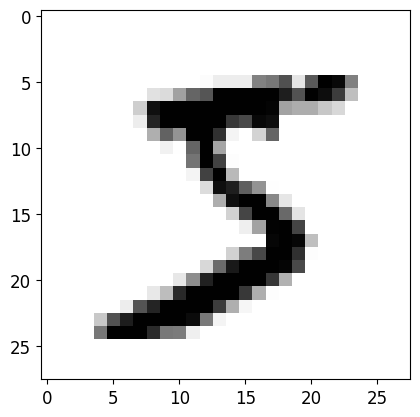

In [ ]:
plt.imshow(X_train_full[0], cmap="binary")
plt.show()

Let's visualise more examples in a grid to get a better idea of their characteristics.

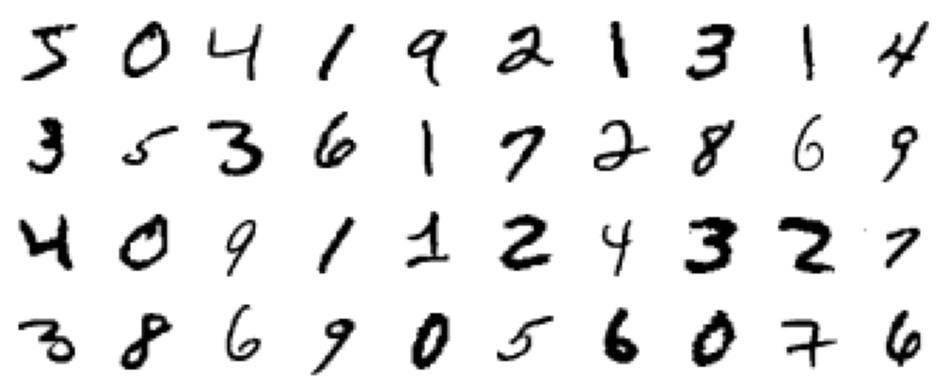

In [ ]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""

    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

    for row in range(n_rows):
        for col in range(n_cols):

            # Get next index of image
            index = n_cols * row + col

            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')

    plt.show()

plot_examples(X_train_full)

We see that the images are size-normalised and centred. The minimal preprocessing required for this dataset is part of its attraction.

Finally, we need to examine the class labels as this will determine the output encoding of our network.

In [ ]:
# Check the format of the label by looking at the first five examples
print(y_train_full[0:5])

# List all unique labels in the training set
print(np.unique(y_train_full))

[5 0 4 1 9]
[0 1 2 3 4 5 6 7 8 9]


As expected, we have ten labels corresponding to the different digits. The labels are provided as indices, as opposed to one hot vectors (where 3 would be represented as ```[0001000000]```).

### Creating a validation set

<img src="https://developers.google.com/static/machine-learning/crash-course/images/PartitionThreeSets.png" width=600>

<img src="https://developers.google.com/static/machine-learning/crash-course/images/workflow_with_validation_set.svg" width=600>

When training and tuning neural networks, having a third data split called the validation set is very useful. During training we will need to determine the appropriate point to stop training to minimise overfitting, however we should not use the test set to do this, as we may bias our training process to this particular test set, and it would no longer be a fair measure of the generalisation ability of the network. Hence, we can use the validation set for this purpose. Additionally, if we wish to tune hyperparameters it is often infeasible to use k-fold cross validation due to its long runtime, so we are sometimes forced to evaluate a single training run using the validation set instead.

Let's set aside 10% of the original training data for this purpose using sklearn's ```train_test_split```.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9)

### Defining the model

<img src="https://miro.medium.com/v2/resize:fit:1200/1*WzwKtnA0LEhiCGdWTTpLaA.png" width=700>



With our data fully prepared, it is now time to design our multilayer perceptron network. Neural network design can be difficult, with infinite possible combinations of hidden layers and numbers of neurons in each. While an MLP with one hidden layer can model any problem with enough neurons, deeper networks with multiple layers often have much higher parameter efficiency, using less weights (and hence less computation) to solve the same problem.

Although there are few firm rules, with practice and exposure to neural networks in different contexts, you will develop an intuition for the appropriate starting design for your network's hidden layers depending on your problem and computational constraints. Tuning these design parameters and stopping training early to avoid overfitting can also help allevaite concern over the initial design.

Today, we aim to solve a relatively simple task, and importantly, we aim to use a network which we can train and evaluate in a feasible time during today's lab. We have defined the following feedforward network below using Keras' Sequential framework ([documentation](https://keras.io/api/models/)), suitable for models where there is a single stack of layers connected sequentially.

In [ ]:
# Define the model using Sequential API
# Define our MLP layer by layer
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])

or

In [ ]:
# Define the model using Functional API
# Define the input layer
inputs = keras.Input(shape=(28, 28))
# Flatten the input layer
x = keras.layers.Flatten()(inputs)
# Add the first hidden layer
x = keras.layers.Dense(300, activation="tanh")(x)
# Add the second hidden layer
x = keras.layers.Dense(100, activation="tanh")(x)
# Add the output layer
outputs = keras.layers.Dense(10, activation="softmax")(x)

# Create the model
f_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Define the above model using model subclassing

class MLP(keras.Model):

  def __init__(self):
    super().__init__()
    self.flatten = keras.layers.Flatten(input_shape=[28, 28])
    self.d1 = keras.layers.Dense(300, activation="tanh")
    self.d2 = keras.layers.Dense(100, activation="tanh")
    self.d3 = keras.layers.Dense(10, activation="softmax")

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

s_model = MLP()


Note that our first layer simply flattens our input for the next layer. Here, we also define the size of the input, which will determine the number of weights between the input layer and first hidden layer. If you do not specify the input shape, Keras will simply wait until you begin to pass data to the model to actually build it.

For our hidden layers, we have utilised the ReLU activation function (different activation functions are discussed below). Each of these dense layers maintains the weight (and bias) matrix for the connections between the neurons and their inputs.

The final layer is determined by the nature of our classification problem. We have ten classes, so we require 10 output neurons, and we utilise the softmax function ($\frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}}$) to convert the raw outputs of this layer into a probability distribution over the classes.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg" width=400>

With so many connections between the neurons in each layer, we can end up with a lot of parameters. Let's take a look at our model using ```model.summary()```.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can also access the model weights directly and inspect them.

In [ ]:
weights, biases = model.layers[1].get_weights()

In [ ]:
print(weights.shape)
print(biases.shape)

(784, 300)
(300,)


In [ ]:
weights

array([[ 0.01249689,  0.02959474,  0.00913154, ..., -0.04392847,
        -0.04026016,  0.05988197],
       [-0.00208189, -0.01729109, -0.05654741, ...,  0.0187711 ,
        -0.04053098, -0.06402253],
       [-0.01199654, -0.0194563 , -0.06876767, ...,  0.02667224,
         0.04341099, -0.00061384],
       ...,
       [-0.00899506, -0.04113064,  0.04049008, ..., -0.0625561 ,
        -0.06754415,  0.03376541],
       [ 0.06417748,  0.02518734,  0.06568228, ..., -0.02301265,
         0.04106279,  0.02945541],
       [ 0.01842397,  0.04257085,  0.07111305, ...,  0.04582981,
        -0.00699338,  0.07283969]], dtype=float32)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

**Activation Function**: Introduce **non-linearity** into the output of a neuron

<img src="https://media.licdn.com/dms/image/D4D12AQH2F3GJ9wen_Q/article-cover_image-shrink_720_1280/0/1688885174323?e=2147483647&v=beta&t=gFWxErTLLWBc6iRWDxCBRxkdJ7ob24cmjWZAOuKN9o4" width=500>

#### **Discussion Question**

Note that the biases are initially zero, but the weights are initialised to small values. What would happen if the weights were also initialised to zero?

#### Solution

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*WMAfTyHOPmckfmNaWSZUrA.png" width=700>

> **Vanishing gradient and symmetry problem resulting from constant weight initialization**


Geron explains this well in "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow : Concepts, Tools, and Techniques to Build Intelligent Systems" (pp 291):

"If you initialize all weights and biases to zero, then all neurons in a given layer will be perfectly identical, and thus backpropagation will affect them in exactly the same way, so they will remain identical. In other words, despite having hundreds of neurons per layer, your model will act as if it had only one neuron per layer: it won’t be too smart. If instead you randomly initialize the weights, you break the symmetry and allow backpropagation to train a diverse team of neurons."

### Specifying the optimiser and loss function

Before we can use our model, we need to specify some important training parameters and 'compile' the model.

Here, we will use the basic SGD learning algorithm, with a learning rate of 0.1. Our loss function depends on our problem. For a classification task such as ours, we can score the probability distribution output from the softmax layer of our model against the known labels using Cross Entropy loss. Since our labels are in index form rather than encoded as one-hot vectors, as we discussed earlier, we utilise the ```sparse_categorical_crossentropy``` loss. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses) for documentation on the available loss functions in Keras. It is important to ensure the loss function you are using is compatible with the format of your labels.

Finally, we need to tell our model that our metric of interest is accuracy, so that this is reported during training and when we evaluate the model.

In [ ]:
# Instantiate optimiser and compile the model.
opt = keras.optimizers.SGD(learning_rate=5e-2)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

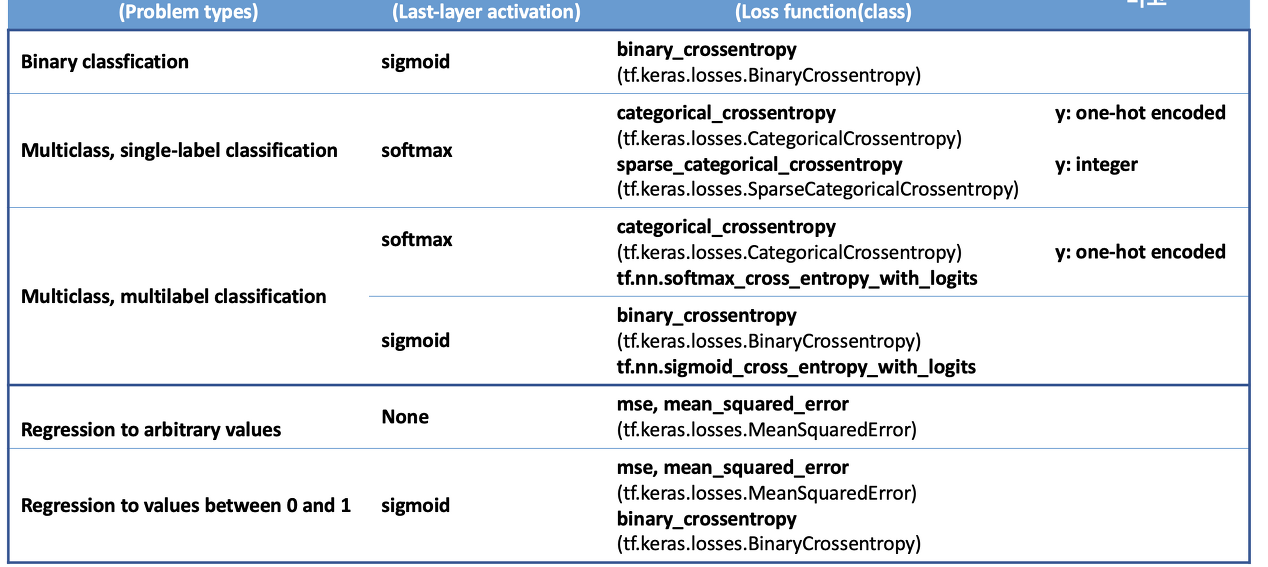

### Training and evaluating the model

Simple model training in Keras is essentially as easy as in sklearn, which is in stark contrast to many other neural network libraries.

The training process may take several minutes to run depending on your hardware. As training progresses, watch carefully how the training and validation accuracy change and spot if the model begins to overfit the training data.

<img src="https://blog.kakaocdn.net/dn/BHLeA/btsaJVbaFdA/FguOrWNXcXRAerbeV63VU0/img.png" width=600>

→ **One Epoch**: one forward pass and one backward pass of all the training examples

In [ ]:
# Train the classifier.
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1688/1688 [==============================] - 7s 3ms/step - loss: 0.3495 - accuracy: 0.9007 - val_loss: 0.2280 - val_accuracy: 0.9347
Epoch 2/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2013 - accuracy: 0.9416 - val_loss: 0.1686 - val_accuracy: 0.9503
Epoch 3/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1509 - accuracy: 0.9561 - val_loss: 0.1385 - val_accuracy: 0.9587
Epoch 4/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1216 - accuracy: 0.9644 - val_loss: 0.1244 - val_accuracy: 0.9632
Epoch 5/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1002 - accuracy: 0.9712 - val_loss: 0.1021 - val_accuracy: 0.9707
Epoch 6/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0847 - accuracy: 0.9750 - val_loss: 0.1023 - val_accuracy: 0.9697
Epoch 7/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0723 - accuracy: 0.9795 - val_loss: 0.0889 - val_accuracy:

Calling the ```fit``` method returns a dictionary of the training history, which we can utilise to visualise the change in training and validation accuracy over time.

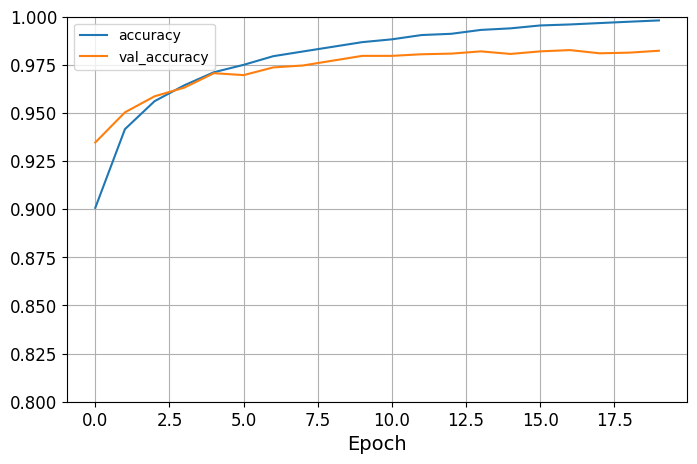

In [ ]:
import pandas as pd

# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

#### **Dicussion Question**:

What is the meaning of validation accuracy?

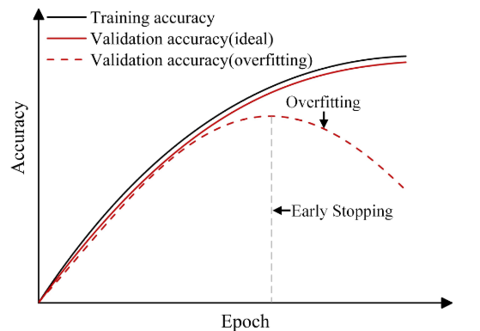

Evidently, choosing the appropriate place to stop our training is important. While this can be done manually, there are also different methods (such as [Keras callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) to automate 'early stopping' from the validation accuracy trends.

#### Check the model's generalisation

To ultimately check the model's generalisation ability, we should evaluate on the test set, which had no influence in the training process.

In [ ]:
# Evaluate the classifier on the test data.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0646 - accuracy: 0.9795
Accuracy on test data: 0.9795


We can also look directly at our model's predictions. The ```predict``` method will return the final outputs from our model - recall this was a probability distribution over the different classes.

In [ ]:
# Sample several test examples
X_test_sample = X_test[:3]

# Get probability of each class from model
y_proba = model.predict(X_test_sample).round(2)
print(y_proba)

1/1 [==============================] - 0s 79ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


To get the index of the class with the maximum probability (our model's class prediction), we can use the following snippet:

In [ ]:
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)

[7 2 1]


Let's verify the predictions by inspecting the corresponding images.

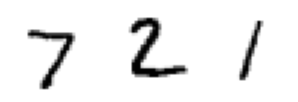

In [ ]:
plot_examples(X_test, n_rows=1, n_cols=3)

## 4. Parameter Search for Neural Networks

Hyperparameter tuning is especially difficult for neural networks due to two factors.

Firstly, the flexibility of neural networks means there are many possible hyperparameters to tweak. In a basic MLP implementation, parameters we can possibly tune include:
- number of hidden layers
- number of neurons in each layer
- activation functions
- learning rate
- optimiser
- batch size

The second difficulty is that the runtime of neural networks is generally much higher than traditional ML algorithms unless we run our algorithms on powerful GPUs (which can better parallelise the computations).

The result is that we often have to tradeoff between an exhaustive parameter search and a long runtime.

Let's define a function which allows us to quickly build a Keras model with our desired parameters. We can use this to try out different parameter combinations!

In [ ]:
def build_mlp(
    n_hidden_layers=2, n_hidden_neurons=50,
    activation_function="relu", input_shape=[28,28]
):
    """Build a Keras MLP for 10 class classification with desired parameters."""

    model = keras.models.Sequential()

    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=[28, 28]))

    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons, activation="relu"))

    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

### Using sklearn grid searches with Keras models

We could conduct a parameter search by writing our own loop over parameter values and simply using the validation set to approximate the performance of the different combinations.

However, it is also possible to use sklearn's parameter search utilities with Keras models. Previously, this functionality was included in Keras as ```keras.wrappers.scikit_learn```, however the functionality has now been taken over by SciKeras

Using SciKeras, we can use a wrapper which allows our Keras classifier to act like a typical sklearn classifier. The wrapper will handle the compilation of our model, and we need to pass the parameters we wish to tune as arguments to its constructor. From there, we can set up a grid search just like we have in the previous weeks!

In [ ]:
from scikeras.wrappers import KerasClassifier

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_mlp,
                                   n_hidden_layers=2,
                                   n_hidden_neurons=50,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

For now, let's consider models with two hidden layers and tune over several other parameters.

The following cell will take a long time to run (possibly several hours depending on your hardware), and it is **not recommended to run it during the lab**.

In [ ]:
"""This cell has a long runtime. Not recommended during lab."""
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_hidden_neurons": [100, 200],
    "optimizer__lr": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh"]
}

grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=20)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3484 - accuracy: 0.8974
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1578 - accuracy: 0.9544
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1116 - accuracy: 0.9671
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0850 - accuracy: 0.9749
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0670 - accuracy: 0.9800
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0544 - accuracy: 0.9829
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0423 - accuracy: 0.9861
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0342 - accuracy: 0.9891
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0286 - accuracy: 0.9908
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.019

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3636 - accuracy: 0.8890
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1601 - accuracy: 0.9501
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1126 - accuracy: 0.9654
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0860 - accuracy: 0.9736
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0685 - accuracy: 0.9779
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0547 - accuracy: 0.9825
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0435 - accuracy: 0.9868
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0355 - accuracy: 0.9887
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0287 - accuracy: 0.9908
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.023

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3656 - accuracy: 0.8914
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1618 - accuracy: 0.9508
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1118 - accuracy: 0.9660
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0878 - accuracy: 0.9732
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0675 - accuracy: 0.9788
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0547 - accuracy: 0.9829
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0444 - accuracy: 0.9861
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0360 - accuracy: 0.9891
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0278 - accuracy: 0.9920
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.020

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8092 - accuracy: 0.7968
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3523 - accuracy: 0.9008
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2966 - accuracy: 0.9156
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2618 - accuracy: 0.9251
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2361 - accuracy: 0.9342
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2150 - accuracy: 0.9396
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1976 - accuracy: 0.9439
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1822 - accuracy: 0.9486
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1696 - accuracy: 0.9519
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.158

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8908 - accuracy: 0.7729
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3564 - accuracy: 0.8988
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2924 - accuracy: 0.9161
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2560 - accuracy: 0.9258
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2297 - accuracy: 0.9339
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2094 - accuracy: 0.9395
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1923 - accuracy: 0.9445
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1794 - accuracy: 0.9491
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1676 - accuracy: 0.9521
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.157

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8489 - accuracy: 0.7874
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3543 - accuracy: 0.8996
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2962 - accuracy: 0.9153
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2631 - accuracy: 0.9250
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2378 - accuracy: 0.9333
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2180 - accuracy: 0.9375
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2007 - accuracy: 0.9426
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1866 - accuracy: 0.9468
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1739 - accuracy: 0.9504
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.162

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.1128 - accuracy: 0.3264
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.5844 - accuracy: 0.6811
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0795 - accuracy: 0.7799
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7893 - accuracy: 0.8206
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6395 - accuracy: 0.8438
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5527 - accuracy: 0.8593
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4968 - accuracy: 0.8692
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4579 - accuracy: 0.8771
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4296 - accuracy: 0.8837
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.407

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0391 - accuracy: 0.4195
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4472 - accuracy: 0.7043
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9735 - accuracy: 0.7872
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7346 - accuracy: 0.8260
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6119 - accuracy: 0.8470
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5388 - accuracy: 0.8579
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4901 - accuracy: 0.8678
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4553 - accuracy: 0.8753
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4291 - accuracy: 0.8808
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.408

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.0342 - accuracy: 0.4151
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4012 - accuracy: 0.7018
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9326 - accuracy: 0.7933
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7125 - accuracy: 0.8296
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5994 - accuracy: 0.8504
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5310 - accuracy: 0.8635
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4848 - accuracy: 0.8732
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4512 - accuracy: 0.8810
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4260 - accuracy: 0.8859
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.406

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3316 - accuracy: 0.9021
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1427 - accuracy: 0.9574
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0983 - accuracy: 0.9703
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0706 - accuracy: 0.9790
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0538 - accuracy: 0.9839
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0406 - accuracy: 0.9878
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0293 - accuracy: 0.9916
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0234 - accuracy: 0.9932
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0165 - accuracy: 0.9956
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.012

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3310 - accuracy: 0.9012
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1387 - accuracy: 0.9570
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0968 - accuracy: 0.9690
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0716 - accuracy: 0.9771
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0538 - accuracy: 0.9833
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0423 - accuracy: 0.9866
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0311 - accuracy: 0.9902
Epoch 8/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.0229 - accuracy: 0.9933
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0166 - accuracy: 0.9954
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.012

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3339 - accuracy: 0.9011
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1402 - accuracy: 0.9580
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0950 - accuracy: 0.9713
Epoch 4/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.0722 - accuracy: 0.9785
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0528 - accuracy: 0.9841
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0421 - accuracy: 0.9877
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0319 - accuracy: 0.9911
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0243 - accuracy: 0.9929
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0177 - accuracy: 0.9956
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.012

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7816 - accuracy: 0.8013
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3401 - accuracy: 0.9039
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2837 - accuracy: 0.9193
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2493 - accuracy: 0.9302
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2245 - accuracy: 0.9374
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2038 - accuracy: 0.9427
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1869 - accuracy: 0.9471
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1717 - accuracy: 0.9523
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1591 - accuracy: 0.9553
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.148

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7864 - accuracy: 0.8051
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3382 - accuracy: 0.9038
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2804 - accuracy: 0.9188
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2459 - accuracy: 0.9280
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2199 - accuracy: 0.9363
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1988 - accuracy: 0.9430
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1804 - accuracy: 0.9485
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1661 - accuracy: 0.9528
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1531 - accuracy: 0.9560
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.142

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7819 - accuracy: 0.8052
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3418 - accuracy: 0.9035
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2845 - accuracy: 0.9197
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2501 - accuracy: 0.9296
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2240 - accuracy: 0.9370
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2035 - accuracy: 0.9421
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1855 - accuracy: 0.9480
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1710 - accuracy: 0.9522
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1583 - accuracy: 0.9557
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.146

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0409 - accuracy: 0.4215
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3758 - accuracy: 0.7317
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9092 - accuracy: 0.8081
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6924 - accuracy: 0.8404
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5802 - accuracy: 0.8591
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5127 - accuracy: 0.8704
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4679 - accuracy: 0.8789
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4359 - accuracy: 0.8849
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4121 - accuracy: 0.8890
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.393

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.9832 - accuracy: 0.4482
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3005 - accuracy: 0.7281
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8678 - accuracy: 0.8089
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6684 - accuracy: 0.8437
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5633 - accuracy: 0.8624
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4992 - accuracy: 0.8741
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4562 - accuracy: 0.8815
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4254 - accuracy: 0.8869
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4022 - accuracy: 0.8908
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.384

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.0534 - accuracy: 0.4223
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4194 - accuracy: 0.7178
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9442 - accuracy: 0.7943
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7084 - accuracy: 0.8315
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5872 - accuracy: 0.8543
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5151 - accuracy: 0.8675
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4673 - accuracy: 0.8787
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4330 - accuracy: 0.8853
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4075 - accuracy: 0.8913
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.387

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3527 - accuracy: 0.8961
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1571 - accuracy: 0.9530
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1107 - accuracy: 0.9679
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0843 - accuracy: 0.9753
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0668 - accuracy: 0.9802
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0544 - accuracy: 0.9835
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0436 - accuracy: 0.9865
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0347 - accuracy: 0.9890
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0280 - accuracy: 0.9914
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.023

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3522 - accuracy: 0.8923
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1518 - accuracy: 0.9529
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1078 - accuracy: 0.9669
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0829 - accuracy: 0.9742
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0660 - accuracy: 0.9786
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0525 - accuracy: 0.9829
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0406 - accuracy: 0.9875
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0336 - accuracy: 0.9897
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0266 - accuracy: 0.9918
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.020

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3555 - accuracy: 0.8944
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1633 - accuracy: 0.9509
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1141 - accuracy: 0.9650
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0892 - accuracy: 0.9731
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0685 - accuracy: 0.9795
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0556 - accuracy: 0.9824
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0433 - accuracy: 0.9874
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0361 - accuracy: 0.9889
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0292 - accuracy: 0.9909
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.021

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8601 - accuracy: 0.7714
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3608 - accuracy: 0.8974
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3024 - accuracy: 0.9126
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2670 - accuracy: 0.9240
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2406 - accuracy: 0.9313
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2188 - accuracy: 0.9369
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2009 - accuracy: 0.9420
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1847 - accuracy: 0.9468
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1712 - accuracy: 0.9517
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.159

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8616 - accuracy: 0.7754
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3557 - accuracy: 0.8982
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2982 - accuracy: 0.9131
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2650 - accuracy: 0.9235
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2404 - accuracy: 0.9308
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2198 - accuracy: 0.9358
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2017 - accuracy: 0.9419
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1875 - accuracy: 0.9465
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1742 - accuracy: 0.9501
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.162

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8657 - accuracy: 0.7750
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3461 - accuracy: 0.9017
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2899 - accuracy: 0.9169
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2578 - accuracy: 0.9258
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2334 - accuracy: 0.9337
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2137 - accuracy: 0.9385
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1964 - accuracy: 0.9437
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1823 - accuracy: 0.9481
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1698 - accuracy: 0.9522
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.158

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.0099 - accuracy: 0.4032
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3736 - accuracy: 0.7079
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9227 - accuracy: 0.7876
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7059 - accuracy: 0.8284
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5924 - accuracy: 0.8507
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5243 - accuracy: 0.8630
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4794 - accuracy: 0.8728
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4472 - accuracy: 0.8792
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4233 - accuracy: 0.8842
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.404

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 3s 3ms/step - loss: 2.0758 - accuracy: 0.3677
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4909 - accuracy: 0.6592
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0228 - accuracy: 0.7552
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7813 - accuracy: 0.8020
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6486 - accuracy: 0.8338
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5660 - accuracy: 0.8534
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5105 - accuracy: 0.8664
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4711 - accuracy: 0.8745
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4418 - accuracy: 0.8810
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.418

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.1247 - accuracy: 0.3677
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.5686 - accuracy: 0.6856
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0522 - accuracy: 0.7747
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7717 - accuracy: 0.8243
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6289 - accuracy: 0.8486
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5474 - accuracy: 0.8632
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4957 - accuracy: 0.8723
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4597 - accuracy: 0.8790
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4333 - accuracy: 0.8838
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.412

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3277 - accuracy: 0.9041
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1429 - accuracy: 0.9584
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0987 - accuracy: 0.9708
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0712 - accuracy: 0.9798
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0541 - accuracy: 0.9841
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0414 - accuracy: 0.9873
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0317 - accuracy: 0.9906
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0231 - accuracy: 0.9939
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0176 - accuracy: 0.9957
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.013

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3313 - accuracy: 0.9003
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1361 - accuracy: 0.9587
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0955 - accuracy: 0.9704
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0713 - accuracy: 0.9784
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0517 - accuracy: 0.9841
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0409 - accuracy: 0.9873
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0287 - accuracy: 0.9920
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0234 - accuracy: 0.9936
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0170 - accuracy: 0.9956
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.011

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3364 - accuracy: 0.8997
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1427 - accuracy: 0.9578
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0970 - accuracy: 0.9708
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0743 - accuracy: 0.9775
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0538 - accuracy: 0.9840
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0421 - accuracy: 0.9879
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0327 - accuracy: 0.9903
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0244 - accuracy: 0.9934
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0167 - accuracy: 0.9959
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.012

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7833 - accuracy: 0.8028
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3446 - accuracy: 0.9033
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2879 - accuracy: 0.9186
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2525 - accuracy: 0.9289
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2269 - accuracy: 0.9359
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2057 - accuracy: 0.9418
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1883 - accuracy: 0.9462
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1726 - accuracy: 0.9514
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1597 - accuracy: 0.9554
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.148

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7862 - accuracy: 0.7973
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3341 - accuracy: 0.9043
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2792 - accuracy: 0.9193
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2455 - accuracy: 0.9291
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2202 - accuracy: 0.9374
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2000 - accuracy: 0.9430
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1824 - accuracy: 0.9476
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1685 - accuracy: 0.9516
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1557 - accuracy: 0.9557
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.144

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7972 - accuracy: 0.7994
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3381 - accuracy: 0.9043
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2804 - accuracy: 0.9205
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2461 - accuracy: 0.9302
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2198 - accuracy: 0.9377
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1995 - accuracy: 0.9424
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1820 - accuracy: 0.9480
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1678 - accuracy: 0.9523
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1553 - accuracy: 0.9554
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.144

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0700 - accuracy: 0.3901
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4530 - accuracy: 0.7161
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9509 - accuracy: 0.7981
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7063 - accuracy: 0.8351
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5855 - accuracy: 0.8538
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5152 - accuracy: 0.8662
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4692 - accuracy: 0.8752
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4364 - accuracy: 0.8817
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4118 - accuracy: 0.8878
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.392

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0139 - accuracy: 0.4107
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3448 - accuracy: 0.7252
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8892 - accuracy: 0.8079
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6754 - accuracy: 0.8407
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5660 - accuracy: 0.8597
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5007 - accuracy: 0.8712
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4575 - accuracy: 0.8794
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4267 - accuracy: 0.8849
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4035 - accuracy: 0.8895
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.385

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 1.9977 - accuracy: 0.4423
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3232 - accuracy: 0.7560
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8754 - accuracy: 0.8229
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6668 - accuracy: 0.8513
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5598 - accuracy: 0.8666
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4957 - accuracy: 0.8771
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4530 - accuracy: 0.8847
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4220 - accuracy: 0.8904
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3987 - accuracy: 0.8954
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.380

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3512 - accuracy: 0.8954
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1537 - accuracy: 0.9544
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1085 - accuracy: 0.9683
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0810 - accuracy: 0.9765
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0646 - accuracy: 0.9802
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0516 - accuracy: 0.9840
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0413 - accuracy: 0.9879
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0338 - accuracy: 0.9896
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0270 - accuracy: 0.9914
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.020

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3536 - accuracy: 0.8934
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1556 - accuracy: 0.9528
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1108 - accuracy: 0.9649
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0864 - accuracy: 0.9734
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0676 - accuracy: 0.9790
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0561 - accuracy: 0.9818
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0449 - accuracy: 0.9859
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0355 - accuracy: 0.9890
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0282 - accuracy: 0.9908
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.023

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3617 - accuracy: 0.8921
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1566 - accuracy: 0.9523
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1114 - accuracy: 0.9664
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0882 - accuracy: 0.9737
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0673 - accuracy: 0.9795
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0557 - accuracy: 0.9828
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0458 - accuracy: 0.9858
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0351 - accuracy: 0.9895
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0299 - accuracy: 0.9908
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.023

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8407 - accuracy: 0.7860
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3567 - accuracy: 0.8998
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3010 - accuracy: 0.9145
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2674 - accuracy: 0.9242
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2429 - accuracy: 0.9323
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2219 - accuracy: 0.9373
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2044 - accuracy: 0.9425
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1887 - accuracy: 0.9473
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1761 - accuracy: 0.9509
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.164

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7941 - accuracy: 0.7992
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3435 - accuracy: 0.9020
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2883 - accuracy: 0.9164
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2550 - accuracy: 0.9264
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2296 - accuracy: 0.9347
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2093 - accuracy: 0.9392
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1912 - accuracy: 0.9449
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1772 - accuracy: 0.9490
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1644 - accuracy: 0.9530
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.153

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8660 - accuracy: 0.7663
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3658 - accuracy: 0.8969
Epoch 3/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3044 - accuracy: 0.9139
Epoch 4/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.2702 - accuracy: 0.9234
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2445 - accuracy: 0.9302
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2241 - accuracy: 0.9356
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2061 - accuracy: 0.9404
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1915 - accuracy: 0.9453
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1784 - accuracy: 0.9489
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.166

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.1536 - accuracy: 0.3133
Epoch 2/20
1125/1125 [==============================] - 4s 3ms/step - loss: 1.6612 - accuracy: 0.6090
Epoch 3/20
1125/1125 [==============================] - 4s 3ms/step - loss: 1.1511 - accuracy: 0.7270
Epoch 4/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8537 - accuracy: 0.7877
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6926 - accuracy: 0.8269
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5947 - accuracy: 0.8487
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5305 - accuracy: 0.8631
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4856 - accuracy: 0.8732
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4531 - accuracy: 0.8792
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.428

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0351 - accuracy: 0.3598
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4311 - accuracy: 0.7038
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9461 - accuracy: 0.7988
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7090 - accuracy: 0.8331
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5908 - accuracy: 0.8511
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5211 - accuracy: 0.8645
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4749 - accuracy: 0.8731
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4418 - accuracy: 0.8807
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4169 - accuracy: 0.8859
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.397

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0657 - accuracy: 0.3432
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4962 - accuracy: 0.6765
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0052 - accuracy: 0.7897
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7398 - accuracy: 0.8313
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6072 - accuracy: 0.8520
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5321 - accuracy: 0.8631
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4841 - accuracy: 0.8728
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4504 - accuracy: 0.8794
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4254 - accuracy: 0.8857
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.405

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3359 - accuracy: 0.9003
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1410 - accuracy: 0.9579
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0975 - accuracy: 0.9706
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0717 - accuracy: 0.9783
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0545 - accuracy: 0.9836
Epoch 6/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.0408 - accuracy: 0.9876
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0303 - accuracy: 0.9910
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0238 - accuracy: 0.9926
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0167 - accuracy: 0.9956
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.011

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3335 - accuracy: 0.9004
Epoch 2/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.1392 - accuracy: 0.9570
Epoch 3/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.0951 - accuracy: 0.9704
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0702 - accuracy: 0.9782
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0528 - accuracy: 0.9830
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0397 - accuracy: 0.9872
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0296 - accuracy: 0.9908
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0223 - accuracy: 0.9939
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0167 - accuracy: 0.9953
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.011

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3278 - accuracy: 0.9024
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1420 - accuracy: 0.9574
Epoch 3/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.0965 - accuracy: 0.9706
Epoch 4/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.0729 - accuracy: 0.9785
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0527 - accuracy: 0.9841
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0412 - accuracy: 0.9880
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0314 - accuracy: 0.9911
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.0228 - accuracy: 0.9942
Epoch 9/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.0168 - accuracy: 0.9956
Epoch 10/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.012

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7877 - accuracy: 0.7991
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3439 - accuracy: 0.9030
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2876 - accuracy: 0.9172
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2523 - accuracy: 0.9282
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2262 - accuracy: 0.9365
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2048 - accuracy: 0.9419
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1872 - accuracy: 0.9464
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1716 - accuracy: 0.9514
Epoch 9/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.1588 - accuracy: 0.9554
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.147

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7820 - accuracy: 0.7987
Epoch 2/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.3429 - accuracy: 0.9023
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2879 - accuracy: 0.9169
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2541 - accuracy: 0.9267
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2282 - accuracy: 0.9349
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2072 - accuracy: 0.9405
Epoch 7/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.1887 - accuracy: 0.9445
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1744 - accuracy: 0.9491
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1612 - accuracy: 0.9538
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.149

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8276 - accuracy: 0.7922
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.3417 - accuracy: 0.9033
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2832 - accuracy: 0.9194
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2487 - accuracy: 0.9298
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.2228 - accuracy: 0.9384
Epoch 6/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.2025 - accuracy: 0.9425
Epoch 7/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.1849 - accuracy: 0.9484
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1709 - accuracy: 0.9525
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.1582 - accuracy: 0.9559
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.146

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0701 - accuracy: 0.4096
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4446 - accuracy: 0.7071
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.9473 - accuracy: 0.7908
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7097 - accuracy: 0.8306
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5906 - accuracy: 0.8522
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5202 - accuracy: 0.8650
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4738 - accuracy: 0.8752
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4405 - accuracy: 0.8828
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4156 - accuracy: 0.8874
Epoch 10/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.395

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0390 - accuracy: 0.4159
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3681 - accuracy: 0.7495
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8938 - accuracy: 0.8122
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6783 - accuracy: 0.8394
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5705 - accuracy: 0.8556
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5061 - accuracy: 0.8686
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4630 - accuracy: 0.8772
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4321 - accuracy: 0.8831
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4086 - accuracy: 0.8874
Epoch 10/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.390

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 2.0666 - accuracy: 0.3705
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4346 - accuracy: 0.7269
Epoch 3/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.9402 - accuracy: 0.8096
Epoch 4/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.6996 - accuracy: 0.8416
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5802 - accuracy: 0.8596
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.5107 - accuracy: 0.8702
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4653 - accuracy: 0.8795
Epoch 8/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4331 - accuracy: 0.8848
Epoch 9/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.4091 - accuracy: 0.8896
Epoch 10/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.390

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2802 - accuracy: 0.9169
Epoch 2/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1169 - accuracy: 0.9646
Epoch 3/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0793 - accuracy: 0.9754
Epoch 4/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0590 - accuracy: 0.9814
Epoch 5/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0444 - accuracy: 0.9862
Epoch 6/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0346 - accuracy: 0.9892
Epoch 7/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0255 - accuracy: 0.9922
Epoch 8/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0196 - accuracy: 0.9943
Epoch 9/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0138 - accuracy: 0.9963
Epoch 10/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.010

GridSearchCV(cv=3,
             estimator=KerasClassifier(activation_function='relu', loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function build_mlp at 0x7f7de24aaef0>, n_hidden_layers=2, n_hidden_neurons=50, optimizer='sgd', optimizer__lr=0.01),
             param_grid={'activation_function': ['relu', 'sigmoid', 'tanh'],
                         'n_hidden_neurons': [100, 200],
                         'optimizer__lr': [0.1, 0.01, 0.001]},
             verbose=2)

In [ ]:
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model

{'activation_function': 'sigmoid', 'n_hidden_neurons': 200, 'optimizer__lr': 0.1}


For even larger models than the MLPs we have considered here, exhaustive grid search and cross validation quickly become infeasible. Other than using more powerful hardware, one approach is to run a broad initial search using the validation set, and then narrow the search space once appropriate starting parameters are identified. There also exist many algorithsm to more efficiently search the hyperparameter space such as Bayesian Search. Ultimately, however, there is no escpaing neural network's need for computation power and their long runtimes. This is one reason why neural networks are not always the most appropriate solution to your problem.

## 5. Task - Using an MLP for Regression

Today we have demonstrated how to create an image classifier MLP. Beyond multi-class classification problems, MLPs can also be used to solve other types of problems, such as regression and binary classification.

To create an MLP for one of these different problems, you will need to change the output encoding.

For example, a binary classifier should have 1 output neuron and use a logistic output layer activation (values close to 0 represent class 0, values close to 1 represent class 1).

For a regression problem, there should be one output neuron per prediction required. No output activation is necessarily required, but ReLU may be used if the output must be positive, and sigmoid/tanh can be used for bounded outputs. The other change for regression problems is the loss function (cross entropy is not appropriate for regression). Mean squared error (MSE) ([Keras documentation](https://keras.io/api/losses/)) is often used.

Below we have loaded and preprocessed the Boston Housing dataset, which contains 13 numerical attibutes of houses of Boston suburbs in the late 1970s. The target variable is the house price in thousands of dollars. For more details on the actual attributes, you can view this [link](http://lib.stat.cmu.edu/datasets/boston).

In [ ]:
# Load the Boston Housing data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.boston_housing.load_data()

57026/57026 [==============================] - 0s 1us/step


In [ ]:
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (404, 13)
Shape of y_train_full: (404,)
Shape of X_test: (102, 13)
Shape of y_test: (102,)


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Task
Define, **train and evaluate a regression MLP on this dataset**. To achieve this, you will need to:
- Remember to adjust the input shape and output layer appropriately for this dataset
- Compile the model with an appropriate loss function
- Interpret the evaluation, since for this regression problem accuracy is not a valid metric

### Solution:

This is one possible simple solution using the same hidden layer structure as above.

In [ ]:
# Define our Keras model with appropriate input size and output
model = keras.Sequential([
    keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1)
])

# Compile model with MSE loss
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
10/10 [==============================] - 2s 19ms/step - loss: 529.1935 - val_loss: 298.1467
Epoch 2/20
10/10 [==============================] - 0s 8ms/step - loss: 172.6203 - val_loss: 69.2144
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 50.3261 - val_loss: 33.6755
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 30.5413 - val_loss: 25.1286
Epoch 5/20
10/10 [==============================] - 0s 11ms/step - loss: 24.4621 - val_loss: 18.8986
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 21.7018 - val_loss: 16.5547
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 19.7493 - val_loss: 14.8200
Epoch 8/20
10/10 [==============================] - 0s 19ms/step - loss: 18.1297 - val_loss: 13.8111
Epoch 9/20
10/10 [==============================] - 0s 11ms/step - loss: 17.2429 - val_loss: 12.6125
Epoch 10/20
10/10 [==============================] - 0s 13ms/step - loss: 16.2605 - val_l

In [ ]:
# Evaluate the model using MSE as a metric
mse_test = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 8ms/step - loss: 24.9306


In [ ]:
# Examine several model predictions
y_pred = model.predict(X_test[:3])

for i in range(3):
    print(f"Model prediction: {y_pred[i][0]:.2f}; True value: {y_test[i]}")

1/1 [==============================] - 0s 46ms/step
Model prediction: 10.50; True value: 7.2
Model prediction: 16.70; True value: 18.8
Model prediction: 21.47; True value: 19.0


## 6. Summary

Today, we have only scratched the surface of Keras' functionality. It is a rich library with lots of possible customisation, and a 'Functional API' ([documentation](https://keras.io/guides/functional_api/)) to create more complex models. Nevertheless, hopefully this provides a springboard for your further study and utilisation of deep learning libraries.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])

opt = keras.optimizers.SGD(learning_rate=5e-2)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

## Acknowledgements

This tutorial is based on:

Aurelien Geron (2019). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.